# Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 



## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [19]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def fit(self, X, y):
        y = pd.Series(y)
        self.result = y.value_counts().argmax()
        self.prob = y.value_counts(normalize=True)
        return None  # Replace with your code

    def predict(self, X):
        
        return np.full(X.shape[0], self.result)  # Replace with your code

    def predict_proba(self, X):
        
        return np.full((X.shape[0],2), self.prob)  # Replace with your code

    def score(self, X, y):
        
        return pd.Series(y).value_counts(normalize=True).max()  # Replace with your code

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [20]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

AssertionError: 

Below are some tests for `predict_proba`.

In [21]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

AssertionError: 

Below are some tests for `score`.

In [22]:
my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)

(0.504950495049505, 0.504950495049505)

In [23]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

AssertionError: 

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

In [9]:
y_new = y.astype('int')

In [10]:
y_new

id
1698308935             0
1701461182             0
1737479987             0
1741160716             0
1773561338             0
                      ..
1273405198698975232    1
1273408026968457216    1
1273442195161387008    0
1273442469066276864    0
1273442528411385858    0
Name: retweets, Length: 43352, dtype: int32

To make predictions, we'll be using only the content (text) of the tweet. 

In [11]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [30]:
# YOUR COMMENT HERE
countvec = CountVectorizer(stop_words="english")

# YOUR COMMENT HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# YOUR COMMENT HERE
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# YOUR COMMENT HERE
pipe = make_pipeline(countvec, lr)

# # YOUR COMMENT HERE
cross_val_results.mean()

# YOUR COMMENT HERE
lr = LogisticRegression(max_iter=1000)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1464, in fit
    raise ValueError("Penalty term must be positive; got 

NameError: name 'lr' is not defined

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_new, random_state=321)

lr = LogisticRegression(max_iter=1000)

countvec = CountVectorizer(stop_words="english")

pipe = make_pipeline(countvec, lr)

cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

cross_val_results.mean()

fit_time       7.405346
score_time     0.644036
test_score     0.897890
train_score    0.967045
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:5}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [32]:
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train,cv=5, return_train_score=True)
)

In [33]:
cross_val_results

,fit_time,score_time,test_score,train_score
0,8.425176,1.134356,0.899123,0.966014
1,9.552536,1.205310,0.899739,0.968859
2,7.709587,0.611656,0.896356,0.965976
3,7.129921,0.626642,0.898201,0.968552
4,6.996991,0.678621,0.896032,0.965823


<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [34]:
model = DummyClassifier()
model.fit(X_train,y_train)
scores=model.score(X_test,y_test)
scores

0.7313157409116073

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [35]:
pipe.fit(X_train, y_train);

In [36]:
pipe.predict_proba(X_train)

array([[0.45574022, 0.54425978],
       [0.84576507, 0.15423493],
       [0.97217068, 0.02782932],
       ...,
       [0.88591559, 0.11408441],
       [0.98384362, 0.01615638],
       [0.94693606, 0.05306394]])

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [37]:
pipe.named_steps['logisticregression'].classes_

array([0, 1])

In [38]:
idx = pipe.predict_proba(X_test)[:, 1].argmax()

In [39]:
prob = max(pipe.predict_proba(X_test)[:, 1])
prob

0.9999999325416274

In [40]:
X_test.iloc[idx], prob

('Corrupt politician Adam Schiff wants people from the White House to testify in his and Pelosi’s disgraceful Witch Hunt, yet he will not allow a White House lawyer, nor will he allow ANY of our requested witnesses. This is a first in due process and Congressional history!',
 0.9999999325416274)

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [41]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

In [42]:
vec_from_pipe.get_feature_names_out().shape

(40965,)

In [43]:
lr_from_pipe.coef_.shape

(1, 40965)

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [44]:
weight = lr_from_pipe.coef_.ravel()
weight

array([ 0.19196721,  0.04056991, -0.00615275, ...,  0.07845493,
        0.75234511, -0.132576  ])

In [45]:
vec = vec_from_pipe.get_feature_names()

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
words_df = pd.DataFrame(data=weight,index=vec,columns=['coef'])
words_df.sort_values(by='coef',ascending=False)

,coef
harassment,2.731812
mini,2.712447
fake,2.692777
coronavirus,2.434278
transcripts,2.380536
...,...
1pic,-2.295049
trump2016,-2.316015
barackobama,-2.565329
trump2016pic,-2.637256


<br><br>

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [47]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

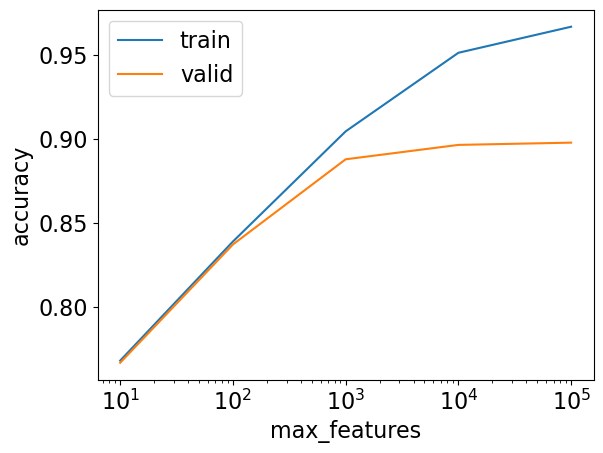

In [31]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [32]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.767854,0.766593
1,100,0.838900,0.837147
2,1000,0.904618,0.887956
3,10000,0.951498,0.896537
4,100000,0.967045,0.897890


<br><br>

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

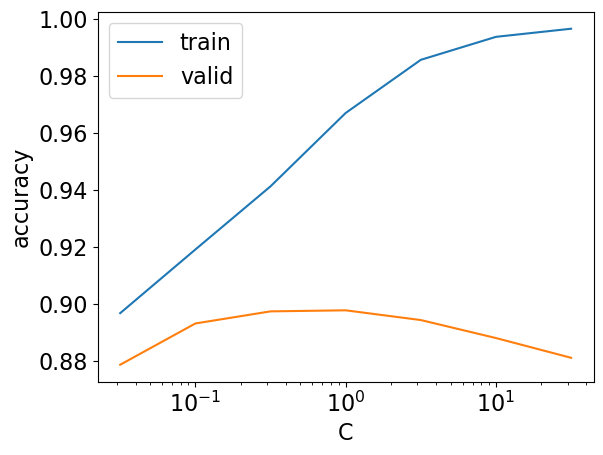

In [33]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [34]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.896898,0.878821
1,0.100000,0.919196,0.893277
2,0.316228,0.941333,0.897521
3,1.000000,0.967045,0.897890
4,3.162278,0.985675,0.894476
5,10.000000,0.993733,0.888171
6,31.622777,0.996578,0.881251


<br><br>

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [2]:
max_features = [10, 100, 1000, 10_000, 100_000]
c_hype = 10.0 ** np.arange(-1.5, 2, 0.5)

for mf in max_features:
    for C in c_hype:  
        pipe = make_pipeline(
                CountVectorizer(stop_words="english",max_features=mf),
                LogisticRegression(max_iter=1000,C=c_hype),
                )
        param_grid = {"max_features" : [10, 100, 1000, 10_000, 100_000],
                      "c_hype" : 10.0 ** np.arange(-1.5, 2, 0.5),}
        grid_search = GridSearchCV(pipe,param_grid,cv=5,n_jobs=-1,return_train_score=True)

In [15]:
max_features = [10, 100, 1000, 10_000, 100_000]
c_hype = 10.0 ** np.arange(-1.5, 2, 0.5)

In [25]:
param_grid = {"countvectorizer__max_features" : max_features,
                      "logisticregression__C" : c_hype}

In [26]:
pipe = make_pipeline(
                CountVectorizer(stop_words="english",max_features=mf),
                LogisticRegression(max_iter=1000,C=c_hype),
                )

In [27]:
pipe

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=100000, stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ]),
                                    max_iter=1000))])

In [28]:
grid_search = GridSearchCV(pipe,param_grid,cv=5,n_jobs=-1,return_train_score=True)

In [30]:
grid_search.fit(X_train,y_train)
# grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=100000,
                                                        stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(C=array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ]),
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ])},
             return_train_score=True)

In [29]:
grid_search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__countvectorizer', 'estimator__logisticregression', 'estimator__countvectorizer__analyzer', 'estimator__countvectorizer__binary', 'estimator__countvectorizer__decode_error', 'estimator__countvectorizer__dtype', 'estimator__countvectorizer__encoding', 'estimator__countvectorizer__input', 'estimator__countvectorizer__lowercase', 'estimator__countvectorizer__max_df', 'estimator__countvectorizer__max_features', 'estimator__countvectorizer__min_df', 'estimator__countvectorizer__ngram_range', 'estimator__countvectorizer__preprocessor', 'estimator__countvectorizer__stop_words', 'estimator__countvectorizer__strip_accents', 'estimator__countvectorizer__token_pattern', 'estimator__countvectorizer__tokenizer', 'estimator__countvectorizer__vocabulary', 'estimator__logisticregression__C', 'estimator__logisticregression__class_weight', 'estimator__logisticregression__dual', 'estimator__logisticr

In [31]:
grid_search.score(X_test,y_test)

0.8993356707879683

<br><br>

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_new, random_state=321)

lr = LogisticRegression(max_iter=1000)

countvec = CountVectorizer(stop_words="english")

pipe = make_pipeline(countvec, lr)

cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

cross_val_results

,fit_time,score_time,test_score,train_score
0,7.629638,0.586664,0.899123,0.966014
1,7.141916,0.653635,0.899739,0.968859
2,7.426753,0.958452,0.896356,0.965976
3,6.906059,0.631628,0.898201,0.968552
4,6.642200,0.571675,0.896032,0.965823


<br><br><br><br>

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

<br><br><br><br>